Exercicio 2 - Lista final - Redes Neurais

In [60]:
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers import Adagrad
from sklearn.decomposition import KernelPCA, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

np.random.seed(42) # setando semente

Carregar o dataset CIFAR-100

In [61]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

Definir as classes que queremos usar (apple, aquarium_fish)

In [62]:
classes = [0, 1]

In [63]:
y_train

array([[19],
       [29],
       [ 0],
       ...,
       [ 3],
       [ 7],
       [73]])

In [64]:
# Filtrar os dados de treino para incluir apenas as 2 classes
train_filter = np.isin(y_train, classes).flatten()
x_train, y_train = x_train[train_filter], y_train[train_filter]

In [65]:
# Filtrar os dados de teste para incluir apenas as 2 classes
test_filter = np.isin(y_test, classes).flatten()
x_test, y_test = x_test[test_filter], y_test[test_filter]

In [66]:
y_train

array([[0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
    

Normalização dos Dados:

In [67]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


In [68]:
# One-Hot Encoding das labels
y_train = to_categorical(y_train, len(classes))
y_test = to_categorical(y_test, len(classes))

In [69]:
y_train

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

Verificando o shape dos dados filtrados

In [70]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (1000, 32, 32, 3)
y_train shape: (1000, 2)
x_test shape: (200, 32, 32, 3)
y_test shape: (200, 2)


Verificando a quantidade de imagens de cada rótulo:

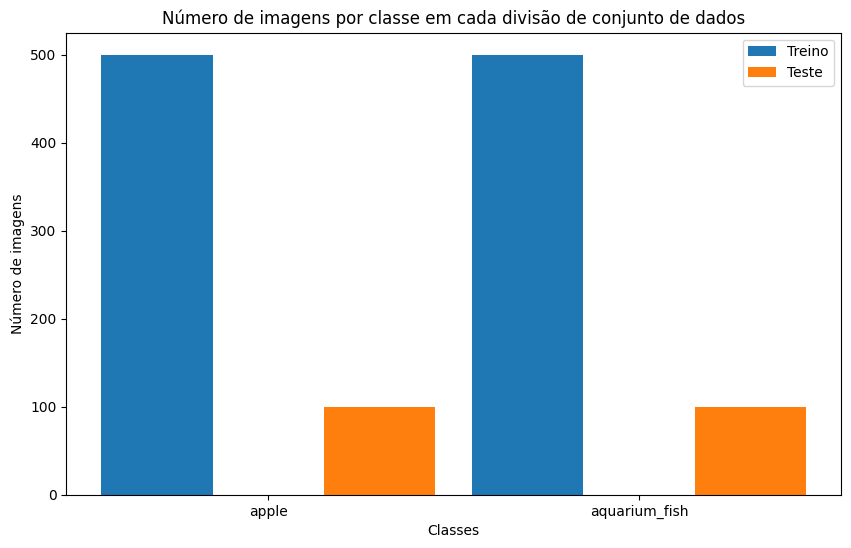

In [71]:
# Contar o número de imagens em cada etapa
train_counts = np.sum(y_train, axis=0)
test_counts = np.sum(y_test, axis=0)
classes = ['apple', 'aquarium_fish']

# Plotando as quantidades de imagens
plt.figure(figsize=(10, 6))

x = np.arange(len(classes))
width = 0.30

plt.bar(x - width, train_counts, width, label='Treino')
plt.bar(x + width, test_counts, width, label='Teste')

plt.xlabel('Classes')
plt.ylabel('Número de imagens')
plt.title('Número de imagens por classe em cada divisão de conjunto de dados')
plt.xticks(x, classes)
plt.legend()
plt.show()

Plotando Algumas Imagens de Cada Classe Selecionada

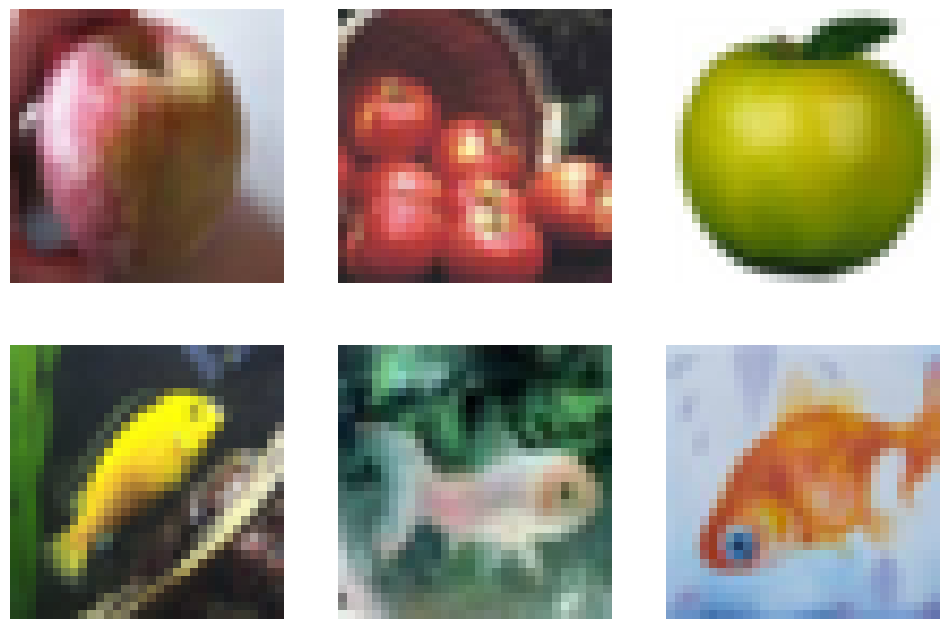

In [72]:
# Função para plotar imagens de uma classe específica
def plot_images_per_class(x_data, y_data, class_indices, class_names, num_images=3):
    plt.figure(figsize=(12, 8))
    for i, class_index in enumerate(class_indices):
        indices = np.where(y_data.argmax(axis=1) == class_index)[0]
        selected_indices = np.random.choice(indices, num_images, replace=False)
        
        for j, img_index in enumerate(selected_indices):
            plt.subplot(len(class_indices), num_images, i * num_images + j + 1)
            plt.imshow(x_data[img_index])
            plt.axis('off')
            if j == 0:
                plt.ylabel(class_names[i], fontsize=12)
    plt.show()

# Plotar imagens de cada classe para o conjunto de treinamento
plot_images_per_class(x_train, y_train, class_indices=[0, 1], class_names=classes)

In [73]:
# Verificar a forma dos rótulos
print("Forma de y_train:", y_train.shape)


# Verificar os valores únicos nos rótulos
print("Valores únicos em y_train:", np.unique(y_train))


Forma de y_train: (1000, 2)
Valores únicos em y_train: [0. 1.]


Configurando KFold para 5 splits

In [74]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

Definindo a arquitetura da CNN e Compilando o modelo para cada fold

In [75]:
fold_accuracies = []
fold_histories = []
all_y_true = []
all_y_pred = []
# Loop sobre os folds
for fold, (train_index, val_index) in enumerate(kf.split(x_train)):
    print(f"Training on Fold {fold+1}...")
    
    # Criar conjuntos de treino e validação para o fold atual
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    activation = 'relu'
    # Definir o modelo CNN (redefinir para cada fold para reiniciar pesos)
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation=activation))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation=activation))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation=activation))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation=activation))
    model.add(Dropout(0.1))
    model.add(Dense(2, activation='softmax'))  # Mudança para apenas 1 unidade com 'sigmoid'
    
    optimizer = Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(x_train_fold, y_train_fold, epochs=25, batch_size=64,
                        validation_data=(x_val_fold, y_val_fold), verbose=1)
    
    fold_histories.append(history)

    val_loss, val_accuracy = model.evaluate(x_val_fold, y_val_fold, verbose=2)
    fold_accuracies.append(val_accuracy)

    # Fazer previsões no conjunto de validação do fold atual
    y_val_pred = model.predict(x_val_fold)
    y_val_pred_classes = (y_val_pred > 0.5).astype(int).flatten()  # Ajuste para binário e achatamento
    y_val_true_classes = y_val_fold.flatten()

    # Armazenar as previsões e verdadeiros para cálculo de métricas globais
    all_y_true.extend(y_val_true_classes)
    all_y_pred.extend(y_val_pred_classes)



Training on Fold 1...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 321ms/step - accuracy: 0.5843 - loss: 0.6709 - val_accuracy: 0.7900 - val_loss: 0.5433
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7689 - loss: 0.5166 - val_accuracy: 0.8050 - val_loss: 0.4189
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8268 - loss: 0.3817 - val_accuracy: 0.7750 - val_loss: 0.4658
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8469 - loss: 0.3630 - val_accuracy: 0.8700 - val_loss: 0.3172
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8917 - loss: 0.2764 - val_accuracy: 0.8750 - val_loss: 0.2678
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8834 - loss: 0.2835 - val_accuracy: 0.9000 - val_loss: 0.2442
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.8845 - loss: 0.2690 - val_accuracy: 0.8750 - val_loss: 0.2725
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9114 - loss: 0.2168 - v

Calculando a média e o desvio padrão da acurácia dos folds

In [76]:
# Calcular a média e o desvio padrão das acurácias dos folds
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)

# Imprimir os resultados
print(f"Média da Acurácia de Validação: {mean_accuracy:.4f}")
print(f"Desvio Padrão da Acurácia de Validação: {std_accuracy:.4f}")

Média da Acurácia de Validação: 0.9340
Desvio Padrão da Acurácia de Validação: 0.0177


Plotando a acurácia e perda para cada fold 

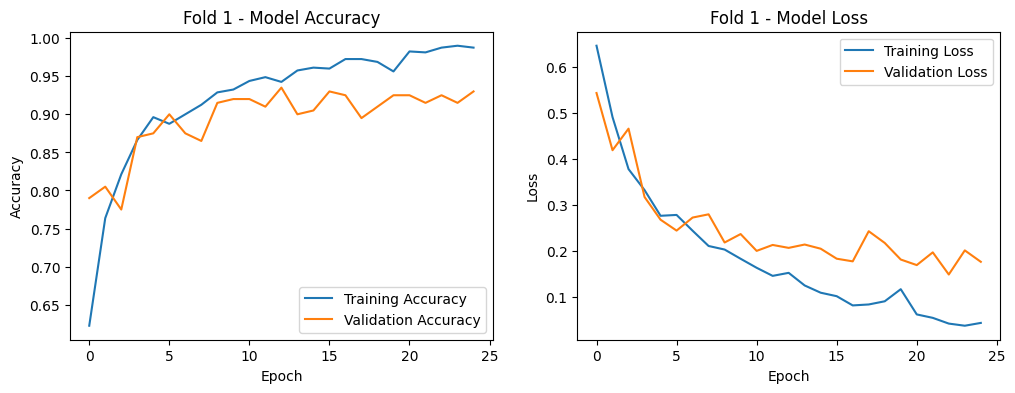

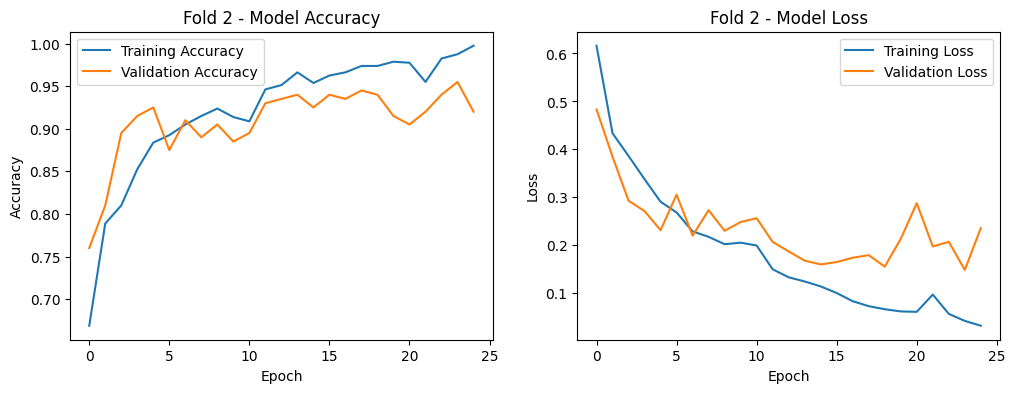

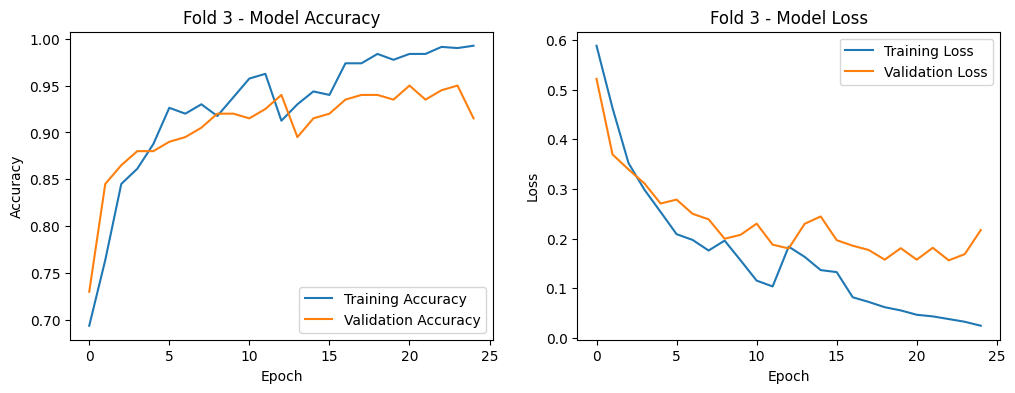

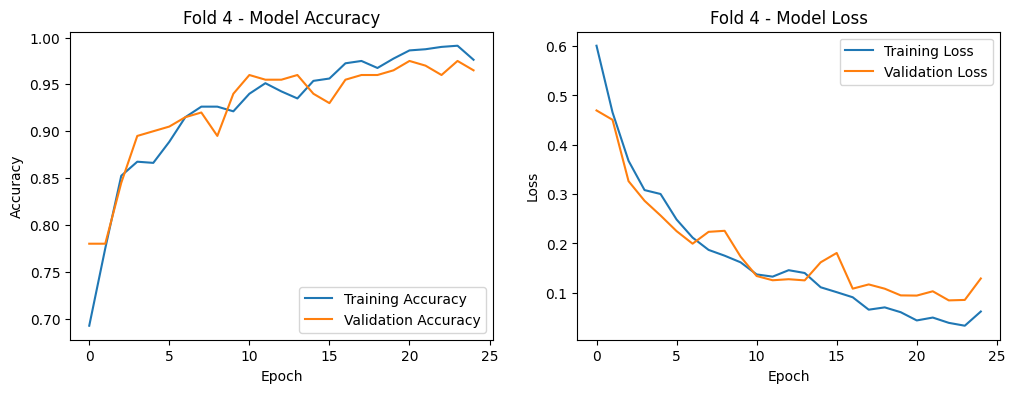

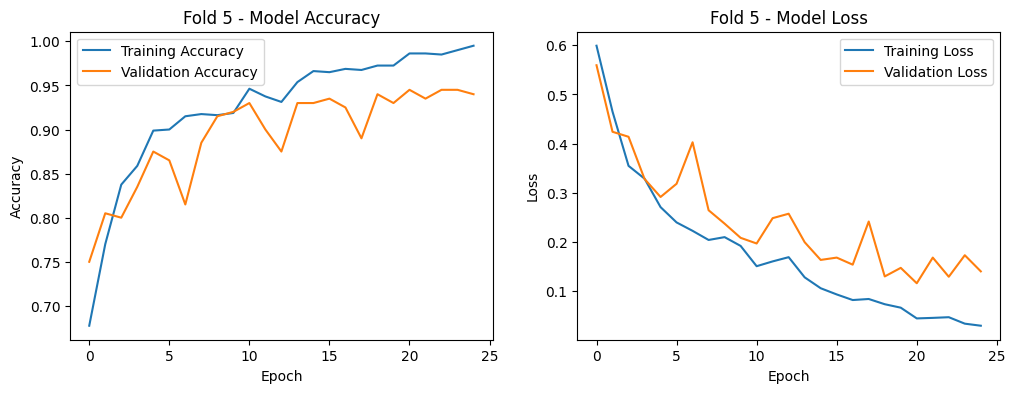

In [77]:
for fold, history in enumerate(fold_histories):
    plt.figure(figsize=(12, 4))
    
    # Plotar a acurácia do treinamento e validação ao longo das épocas
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {fold+1} - Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotar a perda do treinamento e validação ao longo das épocas
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold+1} - Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

Training on Fold 1...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.7364 - loss: 0.6173 - val_accuracy: 0.7900 - val_loss: 0.4530
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7959 - loss: 0.4333 - val_accuracy: 0.8050 - val_loss: 0.4278
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8398 - loss: 0.3758 - val_accuracy: 0.8400 - val_loss: 0.3199
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8333 - loss: 0.3630 - val_accuracy: 0.8650 - val_loss: 0.2979
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8974 - loss: 0.2703 - val_accuracy: 0.8650 - val_loss: 0.2888
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8890 - loss: 0.2736 - val_accuracy: 0.8750 - val_loss: 0.2690
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8858 - loss: 0.2699 - val_accuracy: 0.8800 - val_loss: 0.2523
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9127 - loss: 0.2353 - v

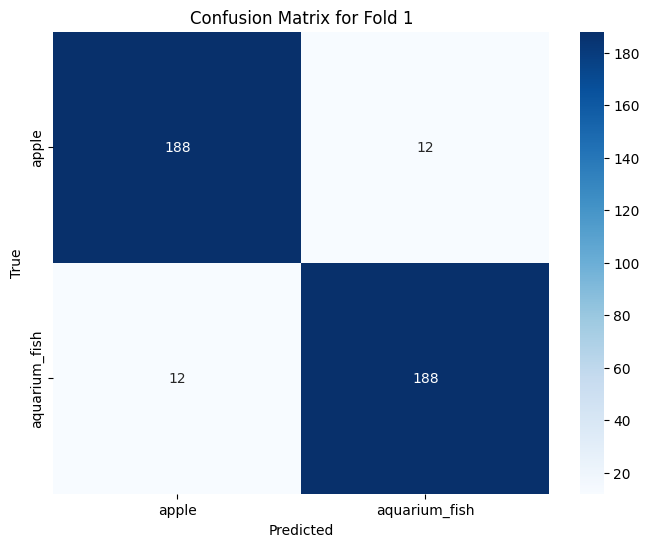

Training on Fold 2...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.5640 - loss: 0.6719 - val_accuracy: 0.8050 - val_loss: 0.5299
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7920 - loss: 0.4909 - val_accuracy: 0.6950 - val_loss: 0.6329
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7708 - loss: 0.5095 - val_accuracy: 0.8500 - val_loss: 0.3910
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8293 - loss: 0.3901 - val_accuracy: 0.8600 - val_loss: 0.3002
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8614 - loss: 0.3250 - val_accuracy: 0.9050 - val_loss: 0.2663
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8902 - loss: 0.2859 - val_accuracy: 0.9200 - val_loss: 0.2392
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9009 - loss: 0.2494 - val_accuracy: 0.9050 - val_loss: 0.2654
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9024 - loss: 0.2319 - va

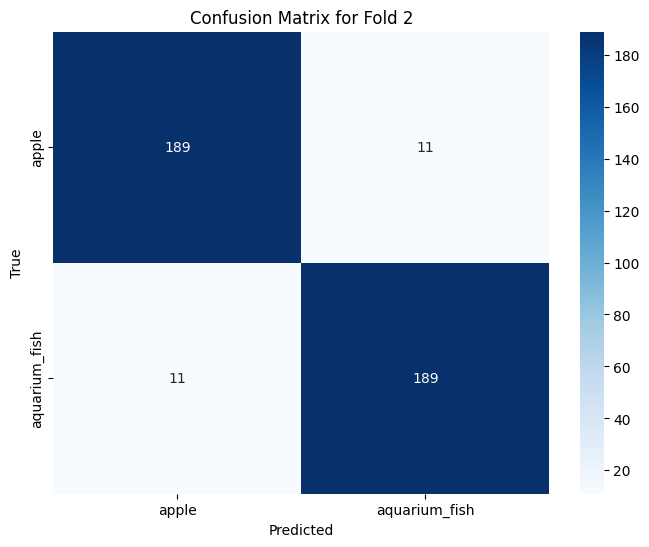

Training on Fold 3...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.5831 - loss: 0.6824 - val_accuracy: 0.7700 - val_loss: 0.5521
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7374 - loss: 0.5265 - val_accuracy: 0.8200 - val_loss: 0.4013
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8475 - loss: 0.3654 - val_accuracy: 0.7900 - val_loss: 0.4677
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8520 - loss: 0.3666 - val_accuracy: 0.8550 - val_loss: 0.3569
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8444 - loss: 0.3387 - val_accuracy: 0.8600 - val_loss: 0.3271
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8829 - loss: 0.2807 - val_accuracy: 0.8700 - val_loss: 0.2993
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9118 - loss: 0.2218 - val_accuracy: 0.8950 - val_loss: 0.2669
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9126 - loss: 0.1987 - va

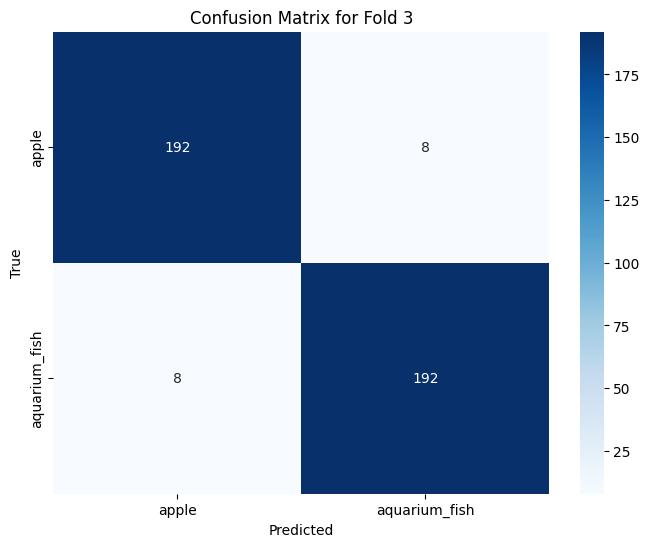

Training on Fold 4...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.6664 - loss: 0.6456 - val_accuracy: 0.7750 - val_loss: 0.4642
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7822 - loss: 0.4458 - val_accuracy: 0.7250 - val_loss: 0.5646
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8212 - loss: 0.4088 - val_accuracy: 0.8600 - val_loss: 0.3235
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8678 - loss: 0.3091 - val_accuracy: 0.9000 - val_loss: 0.2811
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8902 - loss: 0.2788 - val_accuracy: 0.8800 - val_loss: 0.2688
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8844 - loss: 0.2539 - val_accuracy: 0.9000 - val_loss: 0.2573
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9067 - loss: 0.2204 - val_accuracy: 0.9250 - val_loss: 0.2106
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9292 - loss: 0.1755 - v

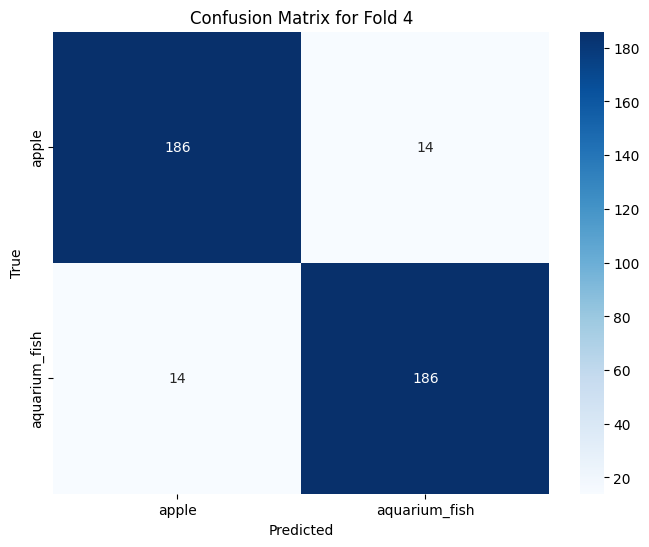

Training on Fold 5...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.6232 - loss: 0.6668 - val_accuracy: 0.7850 - val_loss: 0.4885
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7996 - loss: 0.4487 - val_accuracy: 0.7600 - val_loss: 0.5106
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8376 - loss: 0.3478 - val_accuracy: 0.8550 - val_loss: 0.3341
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8650 - loss: 0.3103 - val_accuracy: 0.8900 - val_loss: 0.3054
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8668 - loss: 0.3089 - val_accuracy: 0.8300 - val_loss: 0.3901
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8752 - loss: 0.2950 - val_accuracy: 0.8650 - val_loss: 0.3104
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9030 - loss: 0.2432 - val_accuracy: 0.8600 - val_loss: 0.3137
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8681 - loss: 0.3275 - va

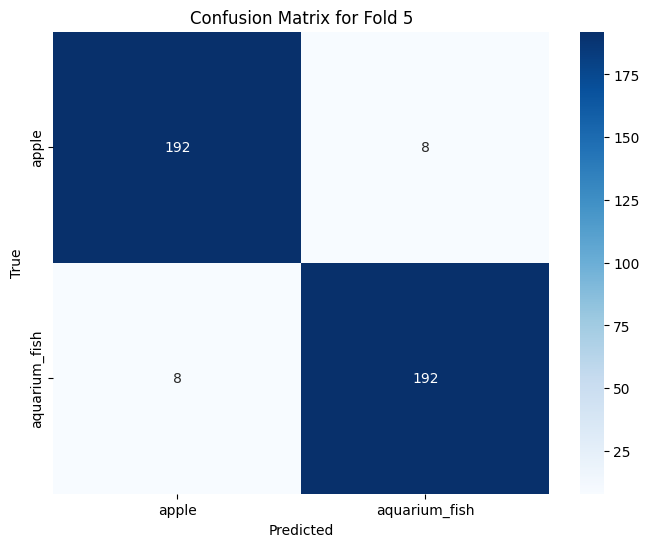

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Variáveis para armazenar métricas globais
all_y_true = []
all_y_pred = []

# Loop sobre os folds
for fold, (train_index, val_index) in enumerate(kf.split(x_train)):
    print(f"Training on Fold {fold+1}...")
    
    # Criar conjuntos de treino e validação para o fold atual
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Definir o modelo CNN (redefinir para cada fold para reiniciar pesos)
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(2, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(x_train_fold, y_train_fold, epochs=25, batch_size=64,
                        validation_data=(x_val_fold, y_val_fold), verbose=1)

    # Fazer previsões no conjunto de validação do fold atual
    y_val_pred = model.predict(x_val_fold)
    y_val_pred_classes = (y_val_pred > 0.5).astype(int).flatten()  # Ajuste para binário
    y_val_true_classes = y_val_fold.flatten()

    # Armazenar previsões e valores verdadeiros para o fold atual
    all_y_true.extend(y_val_true_classes)
    all_y_pred.extend(y_val_pred_classes)
    
    # Gerar e exibir o relatório de classificação para o fold atual
    print(f"\nClassification Report for Fold {fold+1}:")
    print(classification_report(y_val_true_classes, y_val_pred_classes, target_names=classes))

    # Gerar e plotar a matriz de confusão para o fold atual
    conf_matrix = confusion_matrix(y_val_true_classes, y_val_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f"Confusion Matrix for Fold {fold+1}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


In [86]:
# Gerar o relatório de classificação
print("\nClassification Report:")
print(classification_report(all_y_true, all_y_pred, target_names=classes))

# Gerar a matriz de confusão
conf_matrix = confusion_matrix(all_y_true, all_y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)


Classification Report:
               precision    recall  f1-score   support

        apple       0.95      0.95      0.95      1000
aquarium_fish       0.95      0.95      0.95      1000

     accuracy                           0.95      2000
    macro avg       0.95      0.95      0.95      2000
 weighted avg       0.95      0.95      0.95      2000


Confusion Matrix:
[[947  53]
 [ 53 947]]


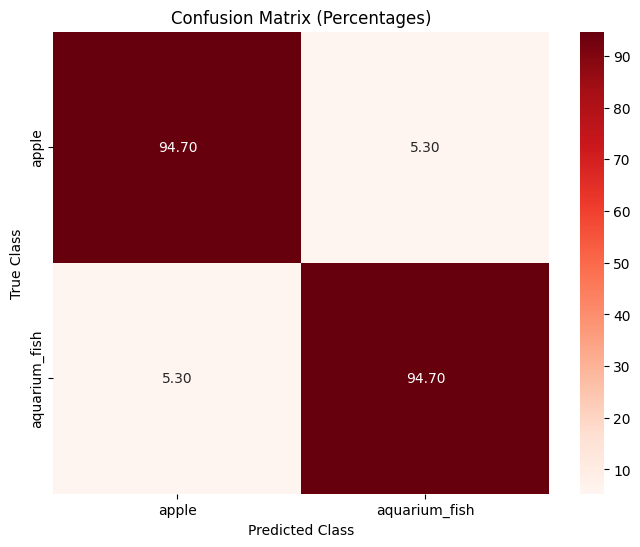

: 

In [87]:
conf_matrix = np.array(conf_matrix)  # Converta para um array NumPy se ainda não for
row_sums = conf_matrix.sum(axis=1, keepdims=True)  # Soma por linha para normalização
conf_matrix_percentage = conf_matrix / row_sums * 100  # Converta para porcentagens

# Plote a matriz de confusão com porcentagens
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Reds',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix (Percentages)')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()